In [18]:
# The Basic Idea in this notebook is to get the maximum accuracy poosible on the CIFAR10 Dataset
# I have implemented the ResNet Architecture

In [19]:
# Importing the required header files
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as T

In [108]:
# Some more header files required
import matplotlib.pyplot as plt
import torchvision

In [20]:
# To change number of filters in residual connection
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

In [21]:
# The Residual Block
class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1):
        super(ResBlock, self).__init__()
        
        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            self.projection = IdentityPadding(num_filters, channels_in, stride)
        
        self.conv1 = nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        self.dropout = nn.Dropout(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        if self.projection:
            residual = self.projection(x)
        out += residual
        out = self.relu2(out)
        return out
# Using Dropout gave better and faster results on the Test Data Set

In [22]:
# Residual Network
class ResNet(nn.Module):
    
    def __init__(self, n=7):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(n, 16, 16, 1)
        self.layers2 = self._make_layer(n, 32, 16, 2)
        self.layers3 = self._make_layer(n, 64, 32, 2)
        self.avgpool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride),*[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [23]:
# define transforms
transform_augment = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [26]:
# For Sampling in the DataSet
class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
    
    def __iter__(self):
        return iter(range(self.start, self.start+self.num_samples))
    
    def __len__(self):
        return self.num_samples

In [28]:
# Splitting into Training and Validation Sets
NUM_TRAIN = 45000
NUM_VAL = 5000
# Loading the datasets
cifar10_train = dset.CIFAR10('./data', train=True, download=True,
                             transform=T.Compose([transform_augment, transform_normalize]))
loader_train = DataLoader(cifar10_train, batch_size=128,
                          sampler=ChunkSampler(NUM_TRAIN))
cifar10_val = dset.CIFAR10('./data', train=True, download=True,
                           transform=transform_normalize)
loader_val = DataLoader(cifar10_train, batch_size=128,
                        sampler=ChunkSampler(NUM_VAL, start=NUM_TRAIN))
cifar10_test = dset.CIFAR10('./data', train=False, download=True,
                            transform=transform_normalize)
loader_test = DataLoader(cifar10_test, batch_size=128)
# Different Batch Sizes of 32, 64, 128 & 256 were tried, Batch Size 128 gave the best results

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [106]:
# Loading a few Images
dataiter = iter(loader_test)
images, labels = dataiter.next()


In [107]:
# Function to show Image
def show(img):
    img = img / 2 + 0.5  # to unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

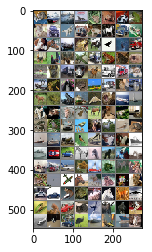

In [109]:
# see the images
show(torchvision.utils.make_grid(images))

In [29]:
# Defining the model
model = ResNet(9)
# Tried different values of depth, a depth of 9 gave the best test acuracy of approx 91%

In [110]:
# Model Description
llayers=list(model.modules())
print(llayers)

[ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (layers1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace)
      (relu2): ReLU(inplace)
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [30]:
# Parameter Count
param_counts = [np.prod(p.size()) for p in model.parameters()]
print(sum(param_counts))

855050


In [32]:
# use gpu for training
if not torch.cuda.is_available():
    print('Error: CUDA library unavailable on system')
global gpu_dtype
gpu_dtype = torch.cuda.FloatTensor
model = model.type(gpu_dtype)

In [33]:
# loss function
criterion = nn.CrossEntropyLoss().cuda()

In [35]:
SCHEDULE_EPOCHS = [50, 5, 5] # divide lr by 10 after each number of epochs
learning_rate = 0.1

In [40]:
# Function for training the model many times
def train(loader_train, model, criterion, optimizer):
    model.train()
    for t, (X, y) in enumerate(loader_train):
        X_var = Variable(X.type(gpu_dtype))
        y_var = Variable(y.type(gpu_dtype)).long()

        scores = model(X_var)

        loss = criterion(scores, y_var)
        if (t+1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t+1, loss.data[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [41]:
# Function to check Accuracy many times
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    for X, y in loader:
        X_var = Variable(X.type(gpu_dtype), volatile=True)

        scores = model(X_var)
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [42]:
for num_epochs in SCHEDULE_EPOCHS:
    print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=0.9, weight_decay=0.0001)
    for epoch in range(num_epochs):
        check_accuracy(model, loader_val)
        print('Starting epoch %d / %d' % (epoch+1, num_epochs))
        train(loader_train, model, criterion, optimizer)
    learning_rate *= 0.1

Training for 50 epochs with learning rate 0.100000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


Got 532 / 5000 correct (10.64)
Starting epoch 1 / 50


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


t = 100, loss = 2.1391
t = 200, loss = 1.9169
t = 300, loss = 1.8839
Got 1520 / 5000 correct (30.40)
Starting epoch 2 / 50
t = 100, loss = 1.6814
t = 200, loss = 1.5387
t = 300, loss = 1.5345
Got 2185 / 5000 correct (43.70)
Starting epoch 3 / 50
t = 100, loss = 1.5141
t = 200, loss = 1.2360
t = 300, loss = 1.3056
Got 2607 / 5000 correct (52.14)
Starting epoch 4 / 50
t = 100, loss = 1.2882
t = 200, loss = 1.1293
t = 300, loss = 1.1676
Got 3079 / 5000 correct (61.58)
Starting epoch 5 / 50
t = 100, loss = 1.1613
t = 200, loss = 0.9759
t = 300, loss = 1.0374
Got 3226 / 5000 correct (64.52)
Starting epoch 6 / 50
t = 100, loss = 1.0097
t = 200, loss = 0.9372
t = 300, loss = 1.0446
Got 3147 / 5000 correct (62.94)
Starting epoch 7 / 50
t = 100, loss = 0.9300
t = 200, loss = 0.7676
t = 300, loss = 0.8828
Got 3480 / 5000 correct (69.60)
Starting epoch 8 / 50
t = 100, loss = 0.8247
t = 200, loss = 0.7633
t = 300, loss = 0.7359
Got 3541 / 5000 correct (70.82)
Starting epoch 9 / 50
t = 100, loss = 

In [43]:
# Test Accuracy
print('Final test accuracy:')
check_accuracy(model, loader_test)

Final test accuracy:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


Got 9098 / 10000 correct (90.98)
